<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education

In [1]:
NAME = "Robina Shaheen"
DATE = "05052020"
COLLABORATORS = ""

# Part II Santa Ana, and Wildfires in the Southern California
## Motivation for vegetation analysis.
The Santa Ana events are characterized by high temperature, low relative humidity. During this time of the year the great basis of the USA and Mojave desert experiences high pressure and hot air masses gush towards the coastal areas in the state of California which experiences unusually low pressure at this time of the year. 
My recent research work *(M. Lin, L. Su, R. Shaheen, J. Fung, M. H. Thiemens (2016) Detection of deep stratospheric intrusion by cosmogenic 35S. Proc. Natl. Acad. Sci. doi:10.1073/pnas.1609919113)* using cosmogenic radio isotope 35-sulfur and numeric modeling of the flow of air masses have shown that large amount of ozone from the stratosphere is also injected into the free troposphere. 
This unique phenomenon which is observed only in this part of the world beg for the question, how this unique combination of heat, low moisture and ozone affects the vegetation. 
The analysis provided in this notebook of vegetation  using normalized vegetation index and normalized burn ratio in the county of San Diego before and after wildfires is a humble effort to answer this question.

### Santa ana conditions and ensuing wildfires
**Wildfire 2014, San Diego, CA (source= wikimedia)**
<a href="https://en.wikipedia.org/wiki/May_2014_San_Diego_County_wildfires" target="_blank">May 2014 Wildfires</a>.

**Figure 1a showing how atmospheric conditions built up to ignite a perfect storm of wildfires in Southern California.**

**Figure 1b. wildfire are shown using Landsat08 satellite image, San Diego California, USA.**


<img style="float: left;" src="storyboardslide-santa_anna winds.jpg" width="440" height="350" />
<img style="float: middle;" src="santa-ana-satellite_wildfires.jpg" width="320" height="80" />


## Work flow to calculate burn area during 2014 San Diego Wildfires using Landsat-8 satellite data.
**Goal**: Automate Normalized Difference nbr Indices using Landsat multispectral bands without clouds.

1. Import packages required for data processing and plotting.
2. Download data using earthpy and set working directory to earth-analytics.
3. Define pixel values to mask clouds and shadows for each satellite scenes. Define a masking variable in a function to clean images.
4. Define a functions to crop images, produce numpy array, metadata, remove clouds and calculate nbr,dnbr  values for each image/ scene.
    * i. Context manager will be used in conjunction with the earthpy functions to perform this task.
    * ii. Read and crop quality assurance files that provides information about the clouds and shadows associated with each image.
    * iii. Read and crop all bands needed for the analysis.
    * iv. Used conditional statement to remove clouds as there may be some clear scenes, without any clouds and shadows.
    * v. stack bands and define plotting extents to be used for figures.
    * vi. Calculate ndvi and nbr using Red, NIR and SWIR bands.
5. Define another function to classify the extent of burning such as severe, moderate and low etc.
    
6. Recall function to calculate ndvi and nbr for each image and to store in the list/ dictionary.
8. Recall classification function to classify Landsat data.
9. Plot nbr, ndvi, dnbr, dndvi and reclassified data for Landsat data.  
10. Calculate burned area using Landsat images acquired before and after wildfires.

In [2]:
# Autograding imports - do not modify this cell
import matplotcheck.notebook as nb
import matplotcheck.autograde as ag
import matplotcheck.raster as rs

## Import Packages

In the cells below packages/modules were imported needed to:
* create plots 
* set  working directory
* download data
* work with rasters and numpy arrays to visualize data
* calculate normalized vegetation index and burn ratio using earthpy 

In [3]:
# YOUR CODE HERE
import warnings
import os
from glob import glob
import re  # regular expressions
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
from shapely.geometry import box
warnings.simplefilter('ignore')

# Adjust plot parameters throughout notebook 
mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.titlesize'] = 20

# Set working directory to 'earth-analytics' and data folder.
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define Functions to automate work flow to 
1. crop and stack image files
2. remove clouds and shadows
3. classify vegetations

In [4]:
# Add your function here. Do NOT modify the function name
def crop_stack_data(files_to_crop, crop_dir_path, crop_bound):
    """Crops a set of tif files and saves them 
    in a crop directory. Returns a stacked numpy 
    array of bands.
    
    Parameters
    ----------
    files_to_crop : list
        List of paths to multispectrum scenes 
        (.tiff) to be cropped.
    
    crop_dir_path : string
        The path to an output directory.  
        use conditional statment to create one,
        if not in existance. 
        The directory will store, 
        cropped and stacked bands.
        
    crop_bound : gpd (GeoPandas GeoDataFrame)
        Vector shape file geodataframe used for 
        cropping area of interest from the files_to_crop.
    
    Returns
    -------
    all_bands_stack : numpy array(s)
        Stacked and cropped numpy array bands 
        (our new aoi's).
    
    fire_crop_bound : GeoPandas GeoDataFrame
        A vector shape file that either shares 
        the crs of the stacked bands or is 
        reprojected from the crop_bound crs.
    """
    if not os.path.exists(crop_dir_path):
        os.mkdir(crop_dir_path)
        
    # Reproject boundary .shp to geotiff crs 
    with rio.open(files_to_crop[0]) as landsat_src:
        if not crop_bound.crs == landsat_src.crs:
            fire_crop_bound = crop_bound.to_crs(
                                  landsat_src.crs)
            extent = plotting_extent(landsat_src)
#         crop_bound = crop_bound.to_crs(src.crs)
 
    #  crop images using earthpy 
    es.crop_all(raster_paths=files_to_crop,
                output_dir=crop_dir_path,
                geoms= fire_crop_bound,
                overwrite=True)
    
    # Retrieve cropped bands from the new directory
    all_bands = sorted(glob(os.path.join(
                       crop_dir_path, "*.tif")))
    # Stack cropped bands
    all_stack_bands, stack_bands_meta = es.stack(all_bands)
    
    # return cropped, stacked bands and fire boundary
    return all_stack_bands, stack_bands_meta, fire_crop_bound

In [5]:
# Add your function here. Do NOT modify the function name
def mask_data(arr, path_to_qa):   
    """Function that masks numpy arrays 
    using qa layer.
    
    Parameters
    ----------
    arr : numpy array
        Numpy array(s) of bands of aoi       
    
    path_to_qa : str
        Path to QA layer(s) associated with each band        
    
    Returns
    -------
    arr : masked numpy array
        Updated numpy array(s) of bands with high cloud
        confidence, clouds and cloud shadows masked.        
    """
    # 1. open the qa layer
    with rio.open(path_to_qa[0]) as src:
        mask_arr = src.read(1)
        
    # Cloud mask values
    high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
    cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
    cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

    all_masked_values = cloud_shadow + cloud + high_cloud_confidence
    
    # 2. Mask the numpy array 
    if any(i in np.unique(mask_arr) for i in all_masked_values):
        landsat_masked_bands = em.mask_pixels(arr,
                                              mask_arr,
                                              vals=all_masked_values)
        return landsat_masked_bands
    else:
        print("There are no pixels to mask")
        return arr

In [6]:
# Add your function here. Do NOT modify the function name
def classify_dnbr(arr):
    """Function that creates a new numpy array of classified
    values using difference normalized burn ratio (dNBR) as
    numpy array. 
    
    Parameters
    ----------
    arr : Numpy array
        Numpy array(s) containing dNBR data.        
    
    Returns
    -------
    arr_class : Numpy array
        Numpy array(s) containing reclassified 
        dNBR values in 5 possible classes.        
    """

    # YOUR CODE HERE
    # bins to define fire severity
    class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]
    
    # code to classify dnbr values 
    arr_reclass = np.digitize(arr, class_bins)
        
    return arr_reclass

# Set workin Directory and base path

In [7]:
# Set working directory using conditional statement
workdir_path = (os.path.join(et.io.HOME, "earth-analytics"))

if os.path.exists(workdir_path):
    os.chdir(workdir_path)
else:
    print("Path does not exist yet, but making it now!")
    os.mkdir(workdir_path)
    os.chdir(workdir_path)

# Check working directory
os.getcwd()

'C:\\Users\\bina_\\earth-analytics'

In [8]:
# Define a base path to access data for all the sites. 
base_path = os.path.join("data","sd_fires_2014", "sites")

# Anayze list of directories in "sites"
all_sites = glob(os.path.join(base_path, "*/"))
all_sites.sort()
all_sites

['data\\sd_fires_2014\\sites\\BERNARDO\\',
 'data\\sd_fires_2014\\sites\\COCOS\\',
 'data\\sd_fires_2014\\sites\\POINSETTIA\\',
 'data\\sd_fires_2014\\sites\\PULGAS\\',
 'data\\sd_fires_2014\\sites\\TOMAHAWK\\']

# Import shape file and view basic coordinate reference system

In [9]:
# Import few shape file and visualize it using geopandas.
base_path = os.path.join("data","sd_fires_2014", "sites")
boundary_path = os.path.join(base_path,
                                "BERNARDO", "vector",
                              "bernardo2014.shp")

# Open a shapefile using geopandas and view/change CRS as needed.
bernardo_bounds = gpd.read_file(boundary_path)
# sjer_boundary= sjer_bounds.to_crs(epsg=32611)
print(bernardo_bounds.total_bounds)
print(bernardo_bounds.shape)
print(bernardo_bounds.crs)

[ 262840.9626 -554981.9991  269077.025  -551039.4485]
(1, 2)
{'init': 'epsg:3310'}


In [10]:
# Define path for shape files
bernardo_path = os.path.join(base_path,  "BERNARDO",
                    "landsat-crop", "landsat20140525",
                             "LC08_L1TP_040037_20140525_20170306_01_T1_pixel_qa.tif")
                             
with rio.open(bernardo_path) as bernardo_src:
    bernardo_csf = bernardo_src.read()
#     clip_extent= [box(*naip_2015_src.bounds)]
    bernardo_csf_meta = bernardo_src.meta
    extent = plotting_extent(bernardo_src)
    bernardo_boundary= bernardo_bounds.to_crs(bernardo_src.crs)

# View and metadata shape 
print(bernardo_csf_meta)
print(bernardo_csf.shape)
print(bernardo_boundary.crs)


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 1.0, 'width': 7691, 'height': 7821, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 370785.0,
       0.0, -30.0, 3787815.0)}
(1, 7821, 7691)
EPSG:32611


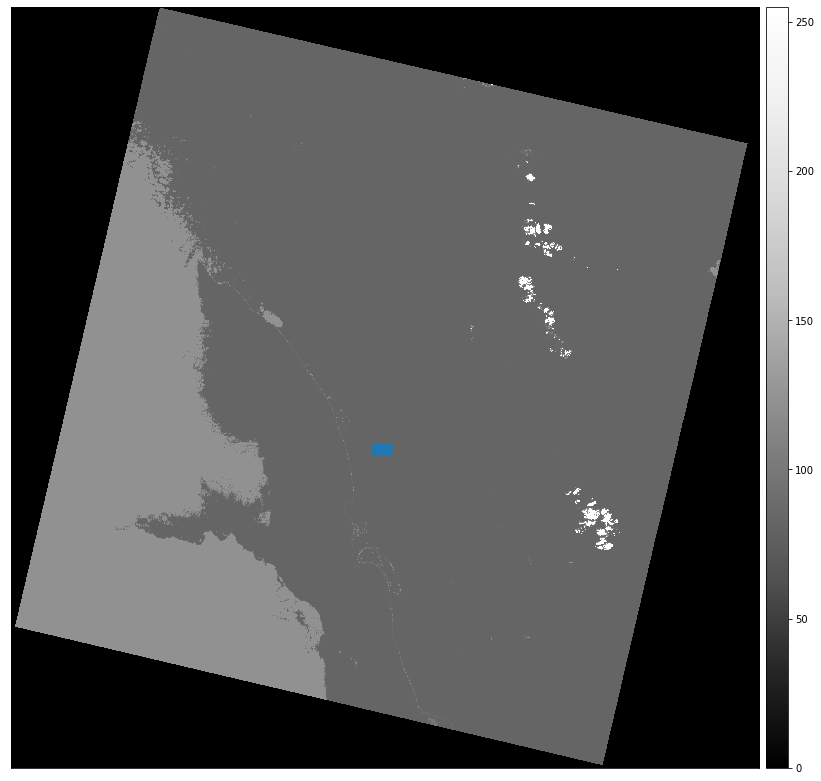

In [11]:
# a quick preview of the Bernardo Fire image for further analysis
fig, ax, = plt.subplots()
ep.plot_bands(bernardo_csf[0], ax= ax, extent = extent)
bernardo_boundary.plot(ax= ax)

# Set Analysis scheme using previously defined functions
To acquire site informaion and store data with date and scene ID's two loops are defined.

Outer loop is a link to site directories.
acquires sites name
define a dynamic boundary shape by a. reading shape files using geopandas in each site directory. b. defines a variable "boundary" used in Function 1 to crop files. c. acquire all sub directories and sort them.
Inner loop acquire is a link to subdirectories (tertiary directory).
acquire dates using index number from the sub directory
acquire all bands for each sites and sort them.
recall Function 1,2 to crop, mask clouds in each image

In [12]:
# Create loop to process Landsat data in this cell
# Setting path to scene directories
# Define list of directories in "sites" 
all_sites = glob(os.path.join(base_path, "*/"))
all_sites.sort()
# print(all_sites)

# Create an empty list to store image files
# Create a dictionary to store site name, date, and  ndvi and nbr
composite_list = []
cleaned_landsat_data = {}
cleaned_landsat_nbr = {}

# ##* Define the directory name, it is an explicit directory.
landsat_dir = "landsat-crop"

# Loop through each site directory
# First loop to go to site direcotry
for site_dir in all_sites:    
    # Get site name
    site = os.path.basename(os.path.normpath(site_dir)) 
#     print("Dyanmic sites:", site)
    
    # Define a dynamic boundary path for the site
    # "_box" is replaced with the '2014.shp'
    boundary_path = os.path.join(site_dir, "vector", 
                                 site + "_box.shp")

    print("Dyanmic boundary path:", boundary_path)
    fire_boundary = gpd.read_file(boundary_path)
#     print("Dyanmic fire boundary:", fire_boundary)
   
    # Get a list of subdirectories for that site
    new_path = os.path.join(site_dir, landsat_dir)
#     print("new path:", new_path)
    # Loop through each subdirectory for site
    # the second loop opens tif files

        # inner loop iterates on each of these (23)x2 subdirectories.
    all_dirs = glob(new_path + "/*/")  
    all_dirs.sort()
    print(all_dirs)
    for scenes in all_dirs:
        date = os.path.basename(os.path.normpath(scenes))[-8:]
#         print(all_dirs)
#         print(date)

#         # Get all tif files in landsat_dir, the directory
        all_scenes = sorted(glob(os.path.join(scenes, "*.tif")))
        crop_path = os.path.join(scenes, "cropped")
        if not os.path.exists(crop_path):
            os.mkdir(crop_path)
#         print(crop_path)

        # crop & stack data
        stacked_bands, stacked_bands_meta, fire_crop_bound = crop_stack_data(
                                     files_to_crop=all_scenes,
                                     crop_dir_path=crop_path,
                                     crop_bound=fire_boundary)

        # Paths to cropped qa and bands
        cropped_qa = glob(os.path.join(crop_path,
                                   "*pixel**crop*.tif"))
        cropped_scenes = sorted(glob(os.path.join(crop_path,
                                              "*band*")))

        # Mask all landsat scenes of bad pixels and remove nodata
        bands_arr, bands_meta = es.stack(cropped_scenes, nodata=1.0)
        saved_array = mask_data(bands_arr, cropped_qa)
        cleaned_landsat_data[site+"_"+ date] = {"stacked_array": saved_array}
#         print(saved_array)
        
        # create plotting extent
        with rio.open(cropped_scenes[3]) as landsat_src:
            extent = plotting_extent(landsat_src)
#         cleaned_landsat_nbr[site] = {date: saved_array}

# # print("plotting extent:", extent)
# # print("fire cropped boundary CRS:", fire_crop_bound.crs)
# print(cleaned_landsat_data)

Dyanmic boundary path: data\sd_fires_2014\sites\BERNARDO\vector\BERNARDO_box.shp
['data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\Landsat20140407\\', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140509\\', 'data\\sd_fires_2014\\sites\\BERNARDO\\landsat-crop\\landsat20140525\\']
There are no pixels to mask
There are no pixels to mask
Dyanmic boundary path: data\sd_fires_2014\sites\COCOS\vector\COCOS_box.shp
['data\\sd_fires_2014\\sites\\COCOS\\landsat-crop\\landsat20140509\\', 'data\\sd_fires_2014\\sites\\COCOS\\landsat-crop\\landsat20140525\\']
There are no pixels to mask
Dyanmic boundary path: data\sd_fires_2014\sites\POINSETTIA\vector\POINSETTIA_box.shp
['data\\sd_fires_2014\\sites\\POINSETTIA\\landsat-crop\\landsat20140509\\', 'data\\sd_fires_2014\\sites\\POINSETTIA\\landsat-crop\\landsat20140525\\']
There are no pixels to mask
Dyanmic boundary path: data\sd_fires_2014\sites\PULGAS\vector\PULGAS_box.shp
['data\\sd_fires_2014\\sites\\PULGAS\\landsat-crop\\landsa

In [13]:
# To View content of the dictionary
print(cleaned_landsat_data.keys())

dict_keys(['BERNARDO_20140407', 'BERNARDO_20140509', 'BERNARDO_20140525', 'COCOS_20140509', 'COCOS_20140525', 'POINSETTIA_20140509', 'POINSETTIA_20140525', 'PULGAS_20140509', 'PULGAS_20140525', 'TOMAHAWK_20140509', 'TOMAHAWK_20140525'])


##  Visualize bands using data storored in the dictionary
view cleaned and cropped images in CIR bands to ensure quality control.

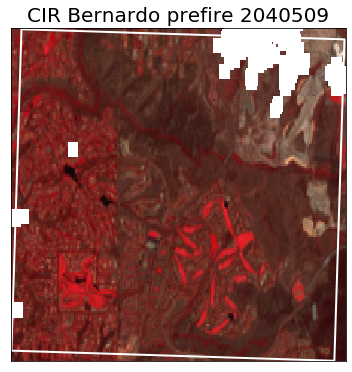

In [58]:
# Visualize few pre and post fire images  
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
offset=-.03
# Plot Landsat CIR
ep.plot_rgb(cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"],
            rgb=[4, 3, 2],
            extent=extent,
            ax=ax,
            title = "CIR Bernardo prefire 2040509")
#             title="Fig. 3 Landsat CIR Composit Image before Bernardo Fire"
#             "\n San Diego, CA, May 09, 2016")
fire_crop_bound.plot(ax=ax, color="None",
                     edgecolor="white", linewidth=2)
plt.savefig('data/output_figures/sandiego_2014_fires/bernardo_prefire_CIR_09may2014.png')
## white spots indicates cloud removed from the image

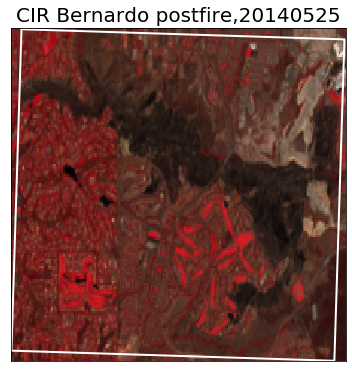

In [59]:
# view post fire images in CIR
# set space for figure
fig, ax = plt.subplots(1, figsize=(6, 10))
offset=-.03
# Plot Landsat CIR
ep.plot_rgb(cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"],
            rgb=[4, 3, 2],
            extent=extent,
            ax=ax,
            title = "CIR Bernardo postfire,20140525")
#             title="Fig. 4 Bernardo, Landsat CIR Composit Image postfire" +
#             "\n San Diego, CA, May 25, 2016")
fire_crop_bound.plot(ax=ax, color="None",
                     edgecolor="white", linewidth=2)
plt.savefig('data/output_figures/sandiego_2014_fires/bernardo_CIR_postfire_25may2014.png')

# Calculate NDVI and normalized differences

In [16]:
# Pre and postfire ndvi and normalized difference- BERNARDO SITE
landsat_prefire_ndvi = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][3])
landsat_postfire_ndvi = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][3])
landsat_dndvi_bernardo = landsat_postfire_ndvi - landsat_prefire_ndvi
# print(landsat_dndvi_bernardo)

In [17]:
# Pre and postfire and the difference between two NDVI_TOMAHAWK
landsat_prefire_ndvi = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][3])
landsat_postfire_ndvi = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140525"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140525"]["stacked_array"][3])
landsat_dndvi_tomahawk = landsat_postfire_ndvi - landsat_prefire_ndvi
# print(landsat_dndvi_tomahawk)

In [18]:
# Landsat NBR and post fire processing-BERNARDO fire
landsat_prefire_nbr_bernardo9 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][6])
landsat_postfire_nbr_bernardo25 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][6])

# Calculate landsat dnbr as pre - post fire nbr and divide into five classes
landsat_dnbr = landsat_prefire_nbr_bernardo9 - landsat_postfire_nbr_bernardo25
landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)
print(landsat_dnbr_reclass)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


In [19]:
# # Landsat NBR processing-TOMAHAWK
# landsat_prefire_nbr = es.normalized_diff(
#     cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][4],
#     cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][6])
# landsat_postfire_nbr = es.normalized_diff(
#     cleaned_landsat_data["TOMAHAWK_20140525"]["stacked_array"][4],
#     cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][6])

# # Calculate landsat dnbr as pre - post fire nbr and divide into five classes
# landsat_dnbr = landsat_prefire_nbr - landsat_postfire_nbr
# landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)
# # print(landsat_dnbr_reclass)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [3 3 2 ... 2 2 2]
 [4 3 3 ... 2 2 2]]


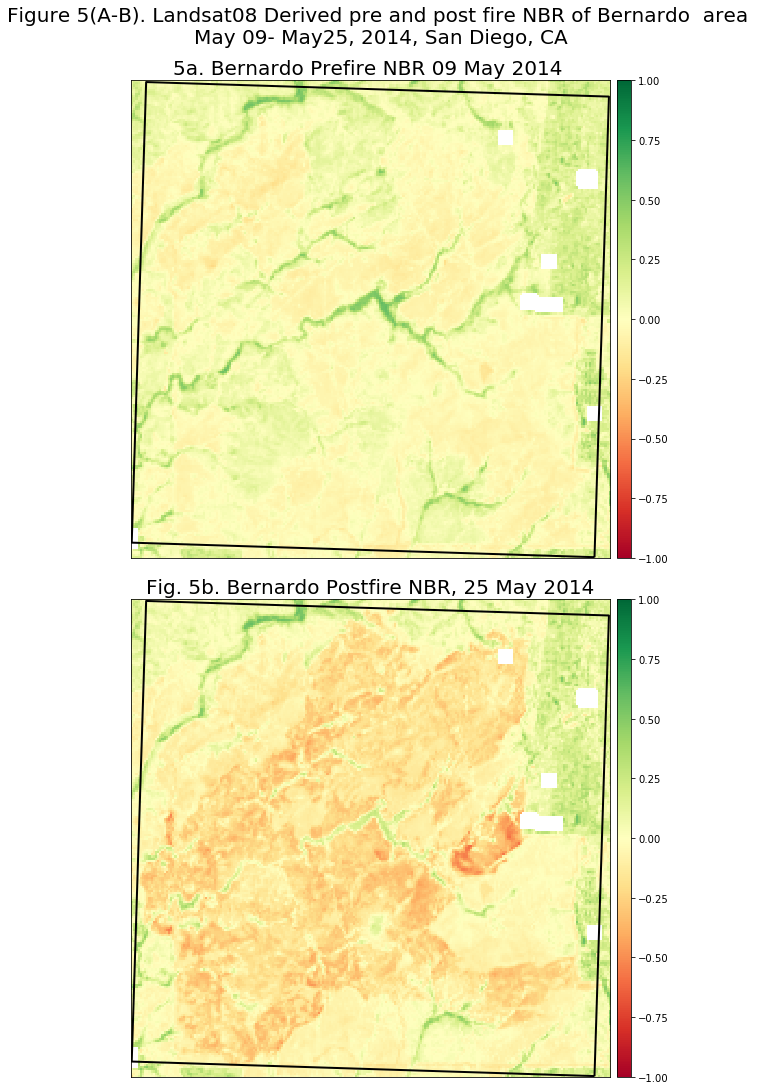

In [37]:
# Landsat NBR and post fire processing-BERNARDO fire
landsat_prefire_nbr_bernardo9 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][6])
landsat_postfire_nbr_bernardo25 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][6])

# Calculate landsat dnbr as pre - post fire nbr and divide into five classes
landsat_dnbr = landsat_prefire_nbr_bernardo9 - landsat_postfire_nbr_bernardo25
landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)

# Define color pallets
colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
                "Moderate Severity", "High Severity"]

cmap = ListedColormap(colors)

# Plot pre, post NBR
fig, [ax1, ax2] = plt.subplots(2,  figsize=(10, 15), constrained_layout=True)
fig.suptitle("""Figure 5(A-B). Landsat08 Derived pre and post fire NBR of Bernardo  area \n""" +
"""May 09- May25, 2014, San Diego, CA""", fontsize = 20)
# Landsat pre and post fire NBR
ep.plot_bands(landsat_prefire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax1,
              extent=extent,
              scale=False,
              title="5a. Bernardo Prefire NBR 09 May 2014 ")
fire_crop_bound.plot(ax=ax1, color='None', edgecolor='black', linewidth=2)
ep.plot_bands(landsat_postfire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax2,
              extent=extent,
              scale=False,
              title="Fig. 5b. Bernardo Postfire NBR, 25 May 2014")
fire_crop_bound.plot(ax=ax2, color='None', edgecolor='black', linewidth=2)


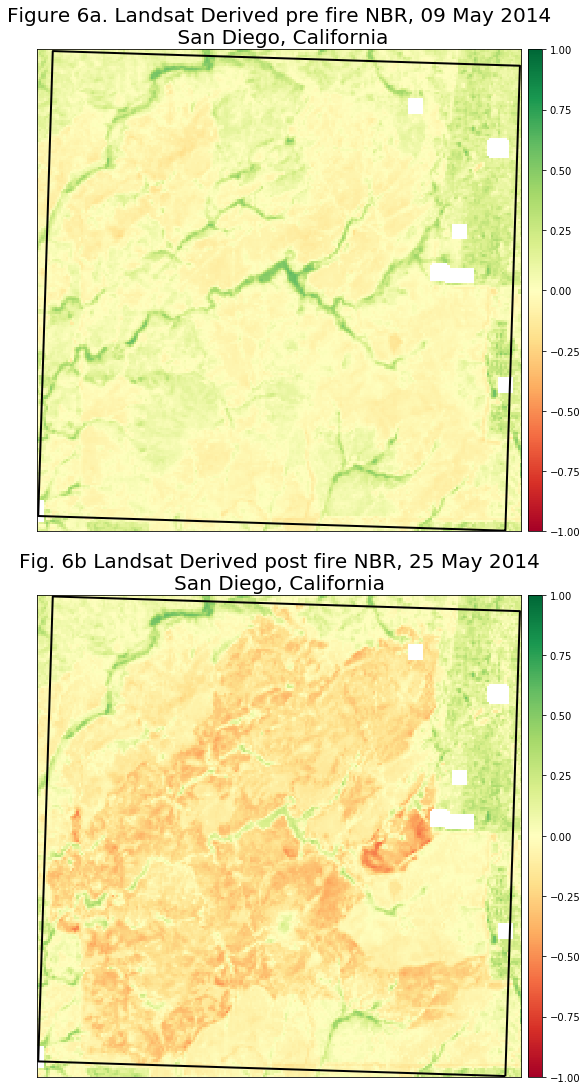

In [38]:
# Pre and postfire and the difference between two NDVI_TOMAHAWK
landsat_prefire_ndvi = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][3])
landsat_postfire_ndvi = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140525"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140525"]["stacked_array"][3])
landsat_dndvi_tomahawk = landsat_postfire_ndvi - landsat_prefire_ndvi
# print(landsat_dndvi_tomahawk)
# Define color pallets
colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
                "Moderate Severity", "High Severity"]

cmap = ListedColormap(colors)

# Plot pre, post NBR
fig, [ax1, ax2] = plt.subplots(2, 1,
                                         figsize=(10, 15), constrained_layout=True)
# Landsat pre and post fire NBR
ep.plot_bands(landsat_prefire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax1,
              extent=extent,
              scale=False,
              title="Figure 6a. Landsat Derived pre fire NBR, 09 May 2014\n " +
                    "San Diego, California")
fire_crop_bound.plot(ax=ax1, color='None', edgecolor='black', linewidth=2)
ep.plot_bands(landsat_postfire_nbr, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax2,
              extent=extent,
              scale=False,
              title="Fig. 6b Landsat Derived post fire NBR, 25 May 2014\n" +
                    "San Diego, California")
fire_crop_bound.plot(ax=ax2, color='None', edgecolor='black', linewidth=2)


## Comparison between two sites Bernardo vs Tomahawk to visualize damages

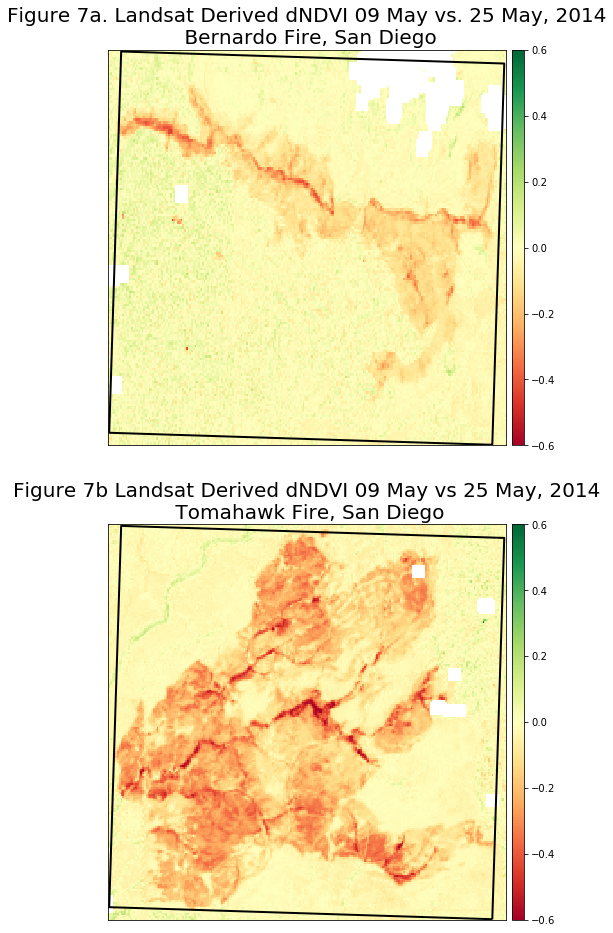

In [39]:
# Plot Difference NDVI for Landsat BERNARDO AND TOMAHAWK together in one figure
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 16))
# Add subtitle 
# fig.suptitle(""" Figure  4(a-b).Severity of Burning obtained using differences in normalized ndvi \n 
#                 Bernardo and Tomahak sites.""", fontsize = 20)

# Plot Landsat dNDVI
ep.plot_bands(landsat_dndvi_bernardo, cmap="RdYlGn",
              vmin=-0.6, vmax=0.6, ax = ax1, extent=extent,
              title="Figure 7a. Landsat Derived dNDVI 09 May vs. 25 May," \
                    " 2014\n Bernardo Fire, San Diego", scale=False)

fire_crop_bound.plot(ax=ax1, color='None', 
                      edgecolor='black', linewidth=2)

# Plot modis dNDVI
ep.plot_bands(landsat_dndvi_tomahawk, cmap="RdYlGn",
              vmin=-0.6, vmax=0.6, ax = ax2, extent=extent,
              title="Figure 7b Landsat Derived dNDVI 09 May vs 25 May," \
                    " 2014\n Tomahawk Fire, San Diego", scale=False)

fire_crop_bound.plot(ax=ax2, color='None', 
                    edgecolor='black', linewidth=2)


# Severity of Burning and the area burned

In [23]:
# Landsat NBR processing-BERNARDO
landsat_prefire_nbr_bernardo7 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140407"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140407"]["stacked_array"][6])
landsat_postfire_nbr_bernardo25 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][6])

# Calculate landsat dnbr as pre - post fire nbr and divide into five classes
landsat_dnbr = landsat_prefire_nbr_bernardo7 - landsat_postfire_nbr_bernardo25
landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)
print(landsat_dnbr_reclass)

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


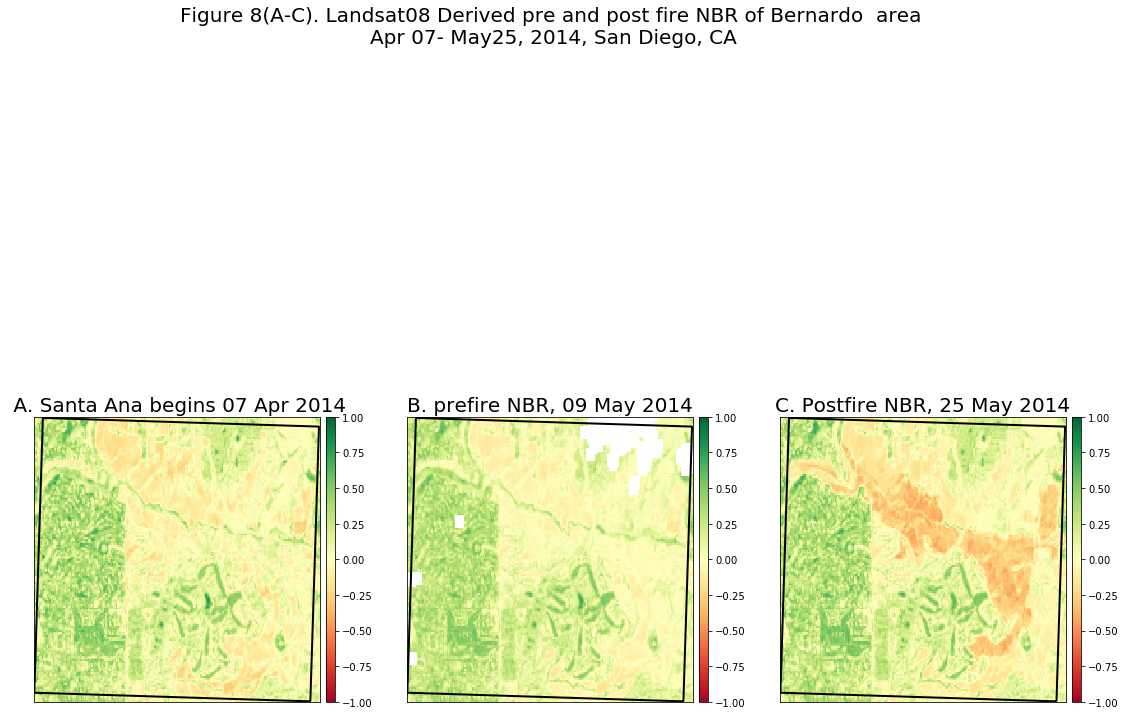

In [60]:
# Plot pre, post NBR Bernardo
fig, [ax1, ax2,ax3] = plt.subplots(1,3, sharey =True, sharex= True, figsize=(16, 16))
offset =0.2
fig.suptitle("""Figure 8(A-C). Landsat08 Derived pre and post fire NBR of Bernardo  area \n""" +
"""Apr 07- May25, 2014, San Diego, CA""", fontsize = 20)

# Define color paletts
colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
                "Moderate Severity", "High Severity"]
cmap = ListedColormap(colors)

# Landsat pre and post fire NBR
ep.plot_bands(landsat_prefire_nbr_bernardo7, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax1,
              extent=extent,
              scale=False,
              title=" A. Santa Ana begins 07 Apr 2014")
fire_crop_bound.plot(ax=ax1, color='None', edgecolor='black', linewidth=2)
ep.plot_bands(landsat_prefire_nbr_bernardo9, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax2,
              extent=extent,
              scale=False,
              title="B. prefire NBR, 09 May 2014")
fire_crop_bound.plot(ax=ax2, color='None', edgecolor='black', linewidth=2)
ep.plot_bands(landsat_postfire_nbr_bernardo25, cmap="RdYlGn",
              vmin=-1, vmax=1, ax=ax3,
              extent=extent,
              scale=False,
              title="C. Postfire NBR, 25 May 2014")
fire_crop_bound.plot(ax=ax3, color='None', edgecolor='black', linewidth=2)
plt.savefig('data/output_figures/sandiego_2014_fires/O3_effects_ndvi_bernardo.png')
fig.tight_layout()

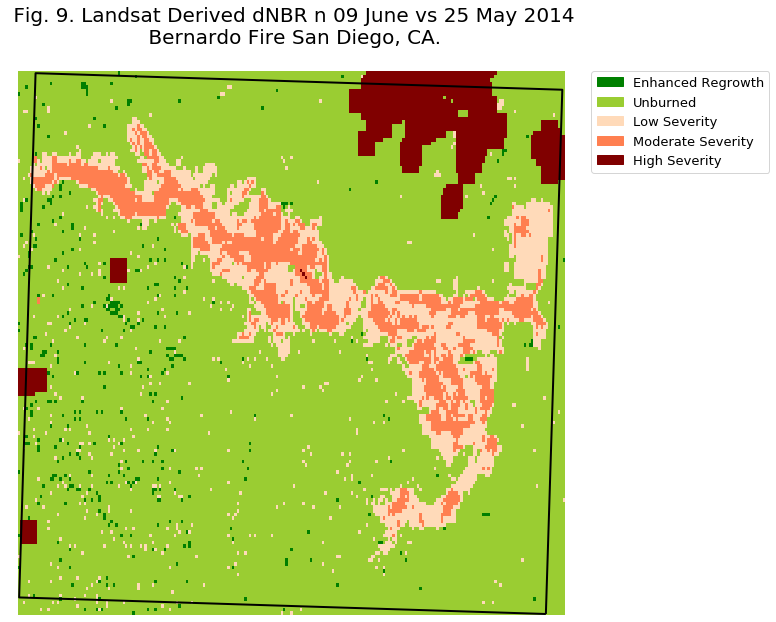

In [46]:
# Landsat NBR and post fire processing-BERNARDO fire
landsat_prefire_nbr_bernardo9 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140509"]["stacked_array"][6])
landsat_postfire_nbr_bernardo25 = es.normalized_diff(
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][4],
    cleaned_landsat_data["BERNARDO_20140525"]["stacked_array"][6])

# Calculate landsat dnbr as pre - post fire nbr and divide into five classes
landsat_dnbr = landsat_prefire_nbr_bernardo9 - landsat_postfire_nbr_bernardo25
landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)
#Creat graph space
fig, ax = plt.subplots(figsize=(10, 10))
# offset = 0.3

colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
               "Moderate Severity", "High Severity"]
cmap = ListedColormap(colors)

# Plot Landsat dNBR
im = ax.imshow(landsat_dnbr_reclass, cmap = cmap, 
                extent=extent)

fire_crop_bound.plot(ax=ax, color='None', 
                      edgecolor='black', linewidth=2)

ep.draw_legend(im, titles=class_labels)
ax.set_title(" Fig. 9. Landsat Derived dNBR n 09 June vs 25 May 2014" \
          "\n Bernardo Fire San Diego, CA.\n")
ax.set_axis_off()
# plt.tight_layout()
plt.savefig('data/output_figures/sandiego_2014_fires/bernardo_fire_dnbr.png')
### DO NOT REMOVE LINE BELOW ###
plot09_landsat_dnbr = nb.convert_axes(plt, which_axes="all")

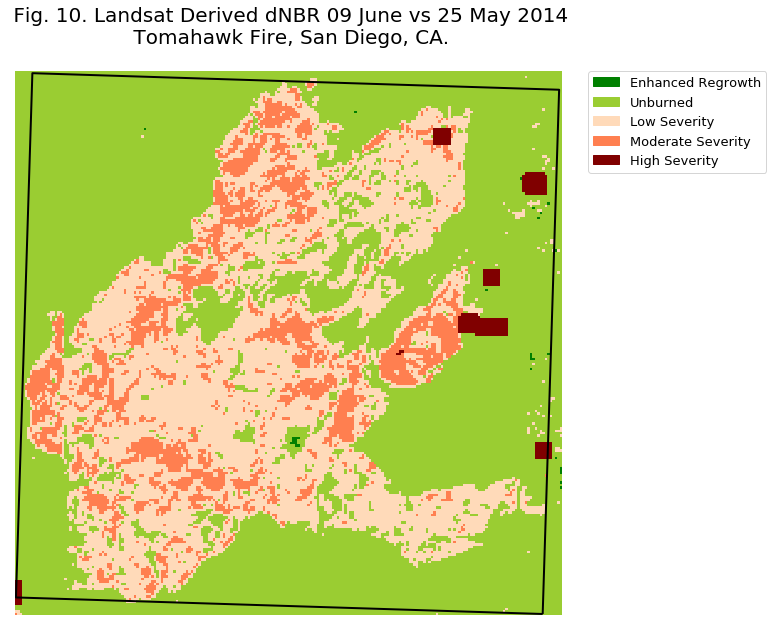

In [62]:
# Landsat NBR processing-TOMAHAWK
landsat_prefire_nbr = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][6])
landsat_postfire_nbr = es.normalized_diff(
    cleaned_landsat_data["TOMAHAWK_20140525"]["stacked_array"][4],
    cleaned_landsat_data["TOMAHAWK_20140509"]["stacked_array"][6])

# Calculate landsat dnbr as pre - post fire nbr and divide into five classes
landsat_dnbr = landsat_prefire_nbr - landsat_postfire_nbr
landsat_dnbr_reclass = classify_dnbr(landsat_dnbr)
# print(landsat_dnbr_reclass)

#Creat graph space
fig, ax = plt.subplots(figsize=(10, 10))
offset = 0.3

colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
class_labels = ["Enhanced Regrowth", "Unburned", "Low Severity",
               "Moderate Severity", "High Severity"]
cmap = ListedColormap(colors)

# Plot Landsat dNBR
im = ax.imshow(landsat_dnbr_reclass, cmap = cmap, 
                extent=extent)

fire_crop_bound.plot(ax=ax, color='None', 
                      edgecolor='black', linewidth=2)

ep.draw_legend(im, titles=class_labels)
ax.set_title(" Fig. 10. Landsat Derived dNBR 09 June vs 25 May 2014" \
          "\n Tomahawk Fire, San Diego, CA.\n")
ax.set_axis_off()
plt.savefig('data/output_figures/sandiego_2014_fires/tomawawk_dnbr.png')

# Burned Area Calculations 
The total area burned in classes 4 and 5 (moderate to high severity) was calculated for the Tomahawk fire

In [47]:
# Total Burned Area in Classes 4 and 5 for Landsat
landsat_pixel_area = int(landsat_src.res[0]) * int(landsat_src.res[0])*int(landsat_src.res[0])

# Lists for dnbr reclassed data and the two areas calculated above.
burned_area_per_source = [landsat_dnbr_reclass]
burned_area_per_pixel = [landsat_pixel_area]

landsat_class_3 = (landsat_dnbr_reclass[landsat_dnbr_reclass == 3]).size
landsat_class_4 = (landsat_dnbr_reclass[landsat_dnbr_reclass == 4]).size
landsat_class_5 = (landsat_dnbr_reclass[landsat_dnbr_reclass == 5]).size

landsat_mod_severity_area = landsat_pixel_area * landsat_class_3
landsat_mod_severity_area = landsat_pixel_area * landsat_class_4
landsat_high_severity_area = landsat_pixel_area * landsat_class_5

landsat_total_burn_area = landsat_mod_severity_area + landsat_high_severity_area


print('Tomhawk Fire burned area =',
      landsat_total_burn_area, 'square meter')
# Tomhawk Fire burned area with class 4,5 only = 4914000 square meter
# Tomhawk Fire burned area with class 3,4,5 = 147420000 square meter
# Tomahak class Diff = 142506000 m^2

# Bernardo Fire burned area 4,5 = 3784500 square meter
# Bernardo Fire burned area 3,4,5 = 113535000 square meter


# Bernardo class diff =109750500 m^2 

Tomhawk Fire burned area = 113535000 square meter


# Results and Conclusions
1. The overall analysis indicates that Santa Ana related wildfires are quite unusual as flames tend to spread far away from the burning sites causing more damage to the residential areas. My atmospheric chemistry analysis note book indicated that the low pressure in the coastel region caused more hot and dry air to flow from the Great Basin of the USA at a speed over 80-100mph.
2. An other serendiptious discovery was the observation of ozone related damages before fires during Santa Ana event of 2014. Figure 8a on Apr.07,2014 indicates that ozone has severly damaged the crop as peak ozone was observed in Apri l2014 in the county of San Diego. The vegetation seems to recover as shown in the pre fire image of Bernardo area (Fig. 8b).
3. Comparison of fig 8b and 8c indicates that 2014 wildfires caused severe damges, however, residential areas were more affected as shown in the scattered red patches. 


# Future Outlook
There are many exciting avenues to proceed this work further using time series of Santa Ana winds.
I am also interested in the understanding the impact of ozone on the vegetations.
How plants develops recovery mechanisms after intense ozone exposure. 
It is an impressive feat for a plant to recover from ozone damages during intense heat as inferred from fig 8a and 8b.
My heart goes out to those unfortunate plants that recovered so efficiently from the ozone damage and ended up as fuel for the *Santa Ana event*. It makes me wonder, 

If these poor Plants are at the *mercy of nature* or is it an after effect of human induced *climate change*?

We will figure it out soon. Please join me if you are interested to find out solutions to mitigate diaster risks through science,
and enjoy playing the role of a detective, a 21st century "*Sherlock Holmz*".

Please stay tuned to know,
**the secret life of molecules in the air** and constant
**struggle of plants against the climate change**.